In [ ]:
## Для данных
import pandas as pd
import numpy as np
## Для графиков
import matplotlib.pyplot as plt
import seaborn as sns
## Для тестов
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## Для машинного обучения
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Читаем датасет, и меняем название первого столбца
dataset = pd.read_csv('/content/Fish.csv', sep=',', encoding='cp1252')
dataset.rename(columns={'ï»¿Species': 'Species'}, inplace=True)

In [ ]:
# Выводи первые 5 строк
dataset.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [ ]:
# Выводим информацию о датасете
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [ ]:
# Функция определяет, является ли столбец числовым или категориальным.
def utils_recognize_type(data, col, max_cat=20):
    if (data[col].dtype == "O") | (data[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

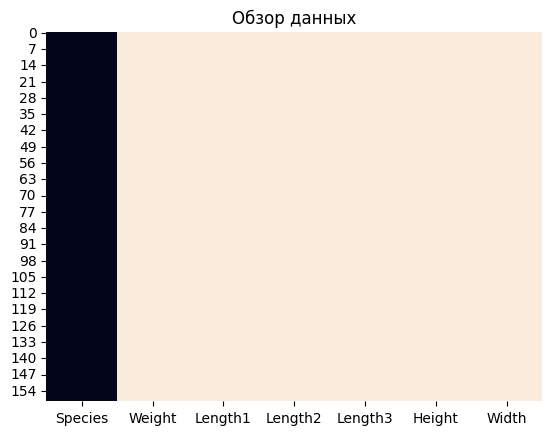

 Categerocial   Numeric   NaN 


In [ ]:
# Формируем словарь.
# Ключи - название столбцов
# Значение - категориальный (cat) или числовой (num)
dic_cols = {col:utils_recognize_type(dataset, col, max_cat=20) for col in dataset.columns}
# Датасет, в котором показано: нулевые значения или нет
heatmap = dataset.isnull()

# Проходим по словарю
for k,v in dic_cols.items():
    if v == "num": # Если значение числовое
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1) # 0.5 - число, 1 - пусто
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1) # 0 - категория, 1 - пусто

# Строим тепловую карту
sns.heatmap(heatmap, cbar=False).set_title('Обзор данных')
plt.show()

# Выводим "легенду"
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

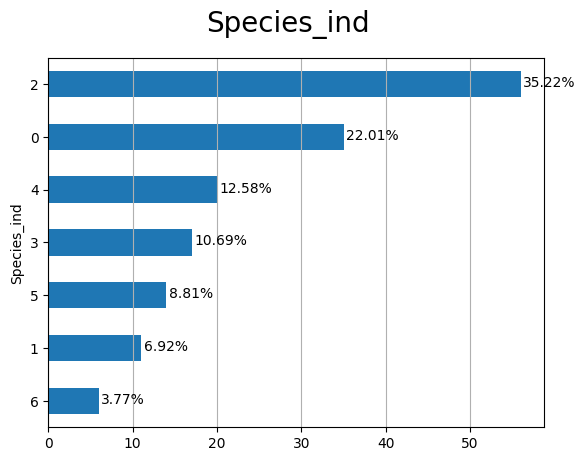

In [ ]:
y = "Species_ind" # Целевая переменная
# Заменяем категориальные переменные
dataset["Species"] = dataset["Species"].astype('category')
dataset["Species_ind"] = dataset["Species"].cat.codes
dataset = dataset.drop('Species', axis=1)
# Считаем количество значений и сортируем их
ax = dataset[y].value_counts().sort_values().plot(kind="barh")

totals= [] # Высота столбцов
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals) # Суммарная высота
# Выводим Названия классов и процентное соотношение
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black')
ax.grid(axis="x") # Выводим сетку по x
plt.suptitle(y, fontsize=20) # Название графика
plt.show()

In [ ]:
# Функция для вывода распределение столбца
def show_dist(x, data):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10))
    fig.suptitle(x, fontsize=20) # Название столбца

    ### Распределение
    ax[0].title.set_text('Распределение') # Название
    variable = data[x].fillna(data[x].mean()) # Замена отсутствующих значений в датафрейме на средние
    breaks = np.quantile(variable, q=np.linspace(0, 1, 11)) # Вычисляем q-й квантиль заданных данных вдоль указанной оси.
    variable = variable[(variable > breaks[0]) & (variable < breaks[10])]
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])  # Создаём гистограмму
    des = data[x].describe()

    # Добавляем на график квантили
    ax[0].axvline(des["25%"], ls='--')
    ax[0].axvline(des["mean"], ls='--')
    ax[0].axvline(des["75%"], ls='--')
    ax[0].grid(True)
    des = round(des, 2).apply(lambda x: str(x))
    box = '\n'.join(("min: " + des["min"], "25%: " + des["25%"], "mean: " + des["mean"], "75%: " + des["75%"], "max: " + des["max"]))
    ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right",
               bbox=dict(boxstyle='round', facecolor='white', alpha=1))

    ### Ящик с усами
    ax[1].title.set_text('Ящик с усами')  # Устанавливаем заголовок
    tmp_dtf = pd.DataFrame(data[x])
    tmp_dtf[x] = np.log(tmp_dtf[x])
    tmp_dtf.boxplot(column=x, ax=ax[1])

    plt.show()

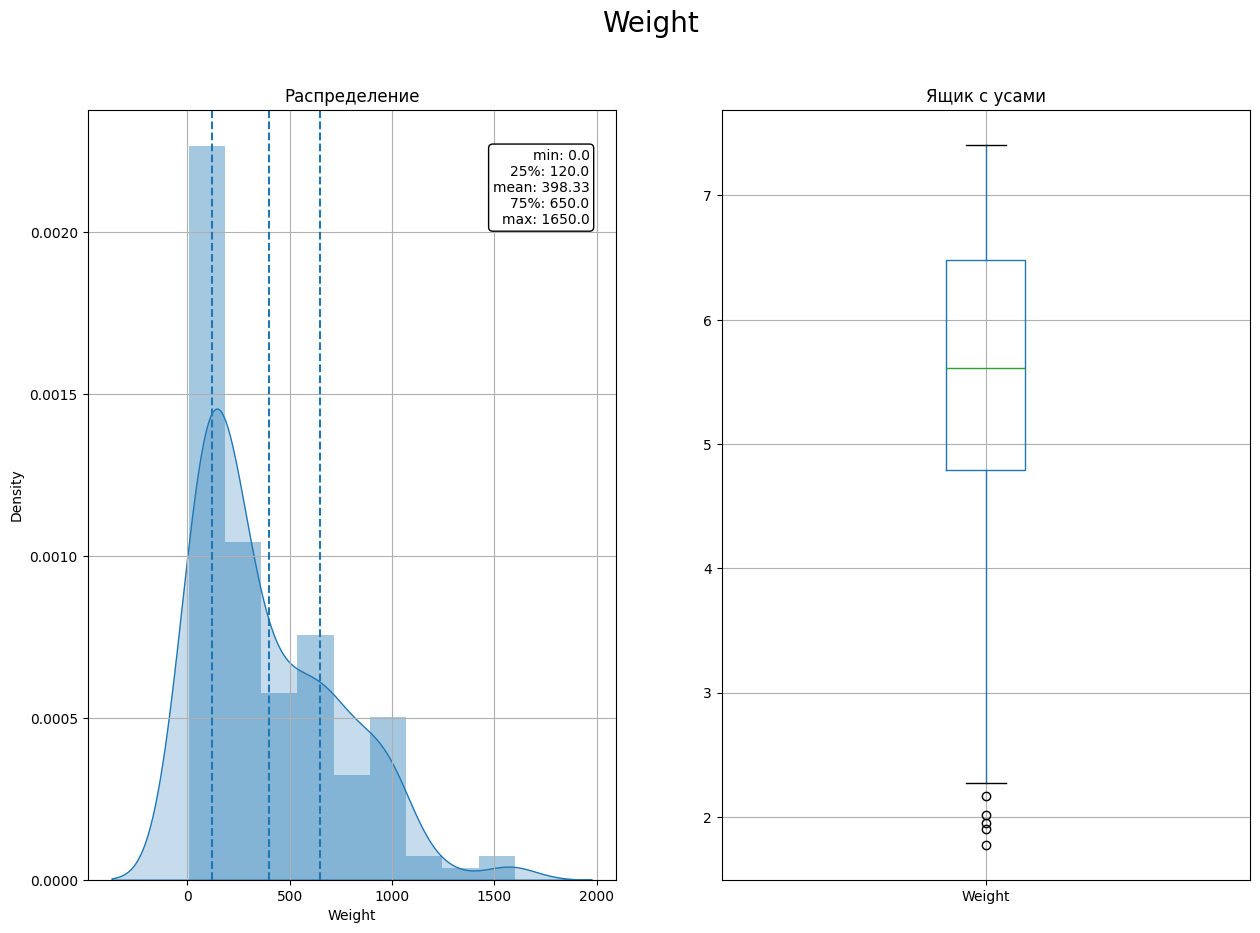

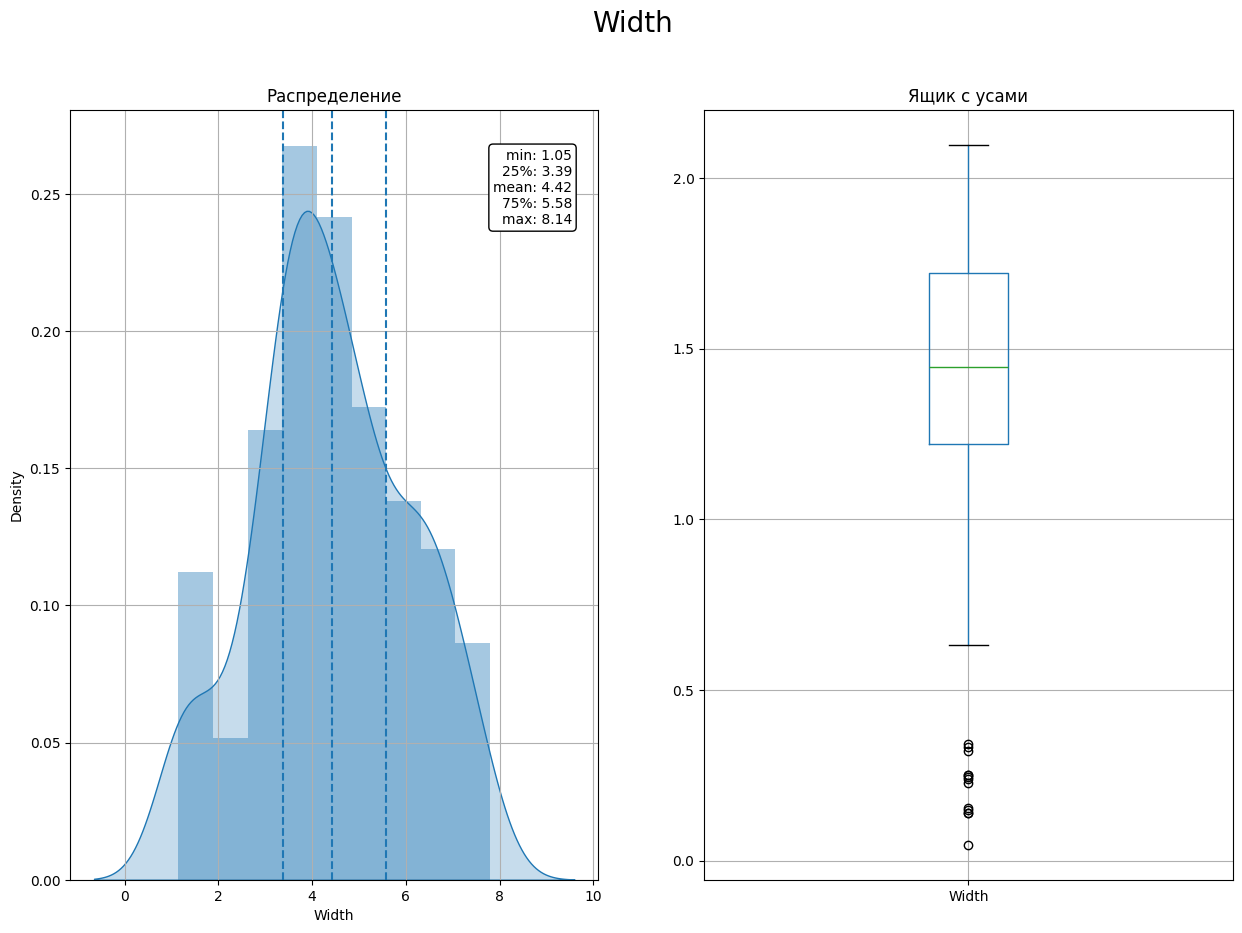

In [ ]:
# Посмотрим на распределение веса рыб и ширины рыб
show_dist('Weight', dataset)
show_dist('Width', dataset)

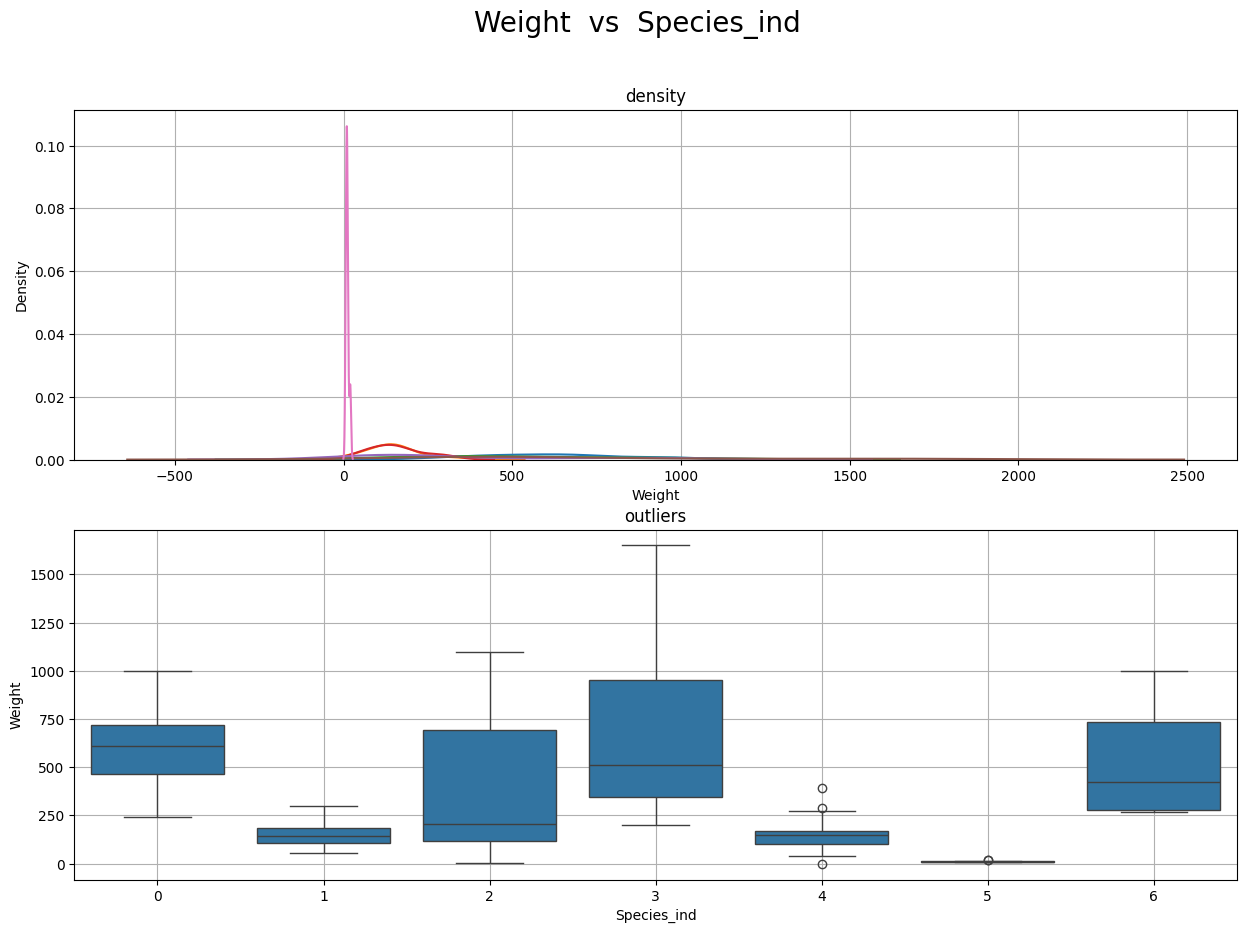

In [ ]:
# Построим графики распределения переменной x для каждого класса целевой переменной
x = "Weight"
fig, ax = plt.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10)) # Распаковываем  кортеж в переменные fig и ax.
# Получаем объект рисунка и массив подграфиков, где первое число - количество строк, второе - столбцов, sharex, sharey задают нужно ли разделять ось между подграфиками
fig.suptitle(x + "  vs  " + y, fontsize=20) # Название

### Распределение
ax[0].title.set_text('density')
for i in dataset[y].unique():  # Перебираем все уникальные значения в столбце y, y = "Species_ind"
    sns.kdeplot(dataset[dataset[y]==i][x], label=i, ax=ax[0]) # Построим график плотности распределения столбца x, при условии, что значение в столбце y совпадет с i
ax[0].grid(True) # Настроим линии сетки.

### Ящик с усами
ax[1].title.set_text('outliers') # Устанавливаем заголовок
sns.boxplot(x=y, y=x, data=dataset, ax=ax[1]) # Нарисуем блочную диаграмму, чтобы показать распределения по категориям.


ax[1].grid(True) # Настроим линии сетки.

plt.show()

In [ ]:
# Функция для преобразования датасета
def prep(data):
    # Удаляем пропуски
    data = data.replace(' ', np.NaN)
    data = data.dropna()
    return  data

In [ ]:
# Разделяем выборку на обучающую и тестовую (30%)
dtf_tr, dtf_t = model_selection.train_test_split(dataset, test_size=0.3)

# Подготавливаем данные в трейне и тесте
dtf_train = prep(dtf_tr)
dtf_test = prep(dtf_t)

# Выводим информацию о выборках
print("X_train shape:", dtf_train.drop("Species_ind",axis=1).shape, "| X_test shape:", dtf_test.drop("Species_ind",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Species_ind"]),2), "| y_test mean:", round(np.mean(dtf_test["Species_ind"]),2))
print(dtf_train.drop("Species_ind",axis=1).shape[1], "columns:", dtf_train.drop("Species_ind",axis=1).columns.to_list())

X_train shape: (111, 6) | X_test shape: (48, 6)
y_train mean: 2.02 | y_test mean: 2.83
6 columns: ['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']


In [ ]:
# смотрим размер полученной выборки трейне: 4922 строки, 23 столбца
dtf_train.shape

(111, 7)

In [ ]:
# Для обучающей выборки берём нужные столбцы и целевую переменную
train_x = dtf_train[['Weight', 'Length1',	'Length2',	'Length3',	'Height',	'Width']]
train_y = dtf_train['Species_ind']

In [ ]:
# Тоже самое делаем для тестовой выборки
test_x = dtf_test[['Weight', 'Length1',	'Length2',	'Length3',	'Height',	'Width']]
test_y = dtf_test['Species_ind']

In [ ]:
# Нормализуем значения
Y = 'Species_ind'
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))#
X = scaler.fit_transform(train_x)

# Нормализованные значения обучающей выборки
train_x_scaled = pd.DataFrame(X, columns=train_x.columns,index=train_x.index )
train_y_scaled = train_y

train_x_scaled.head() # Смотрим, как прошла нормализация

,Weight,Length1,Length2,Length3,Height,Width
86,0.096,0.238095,0.252747,0.247401,0.254321,0.323024
112,0.548,0.571429,0.571429,0.569647,0.531245,0.817261
96,0.180,0.285714,0.296703,0.288981,0.322986,0.368137
32,0.740,0.623810,0.637363,0.700624,0.988229,0.800918
84,0.100,0.214286,0.230769,0.226611,0.230088,0.360201


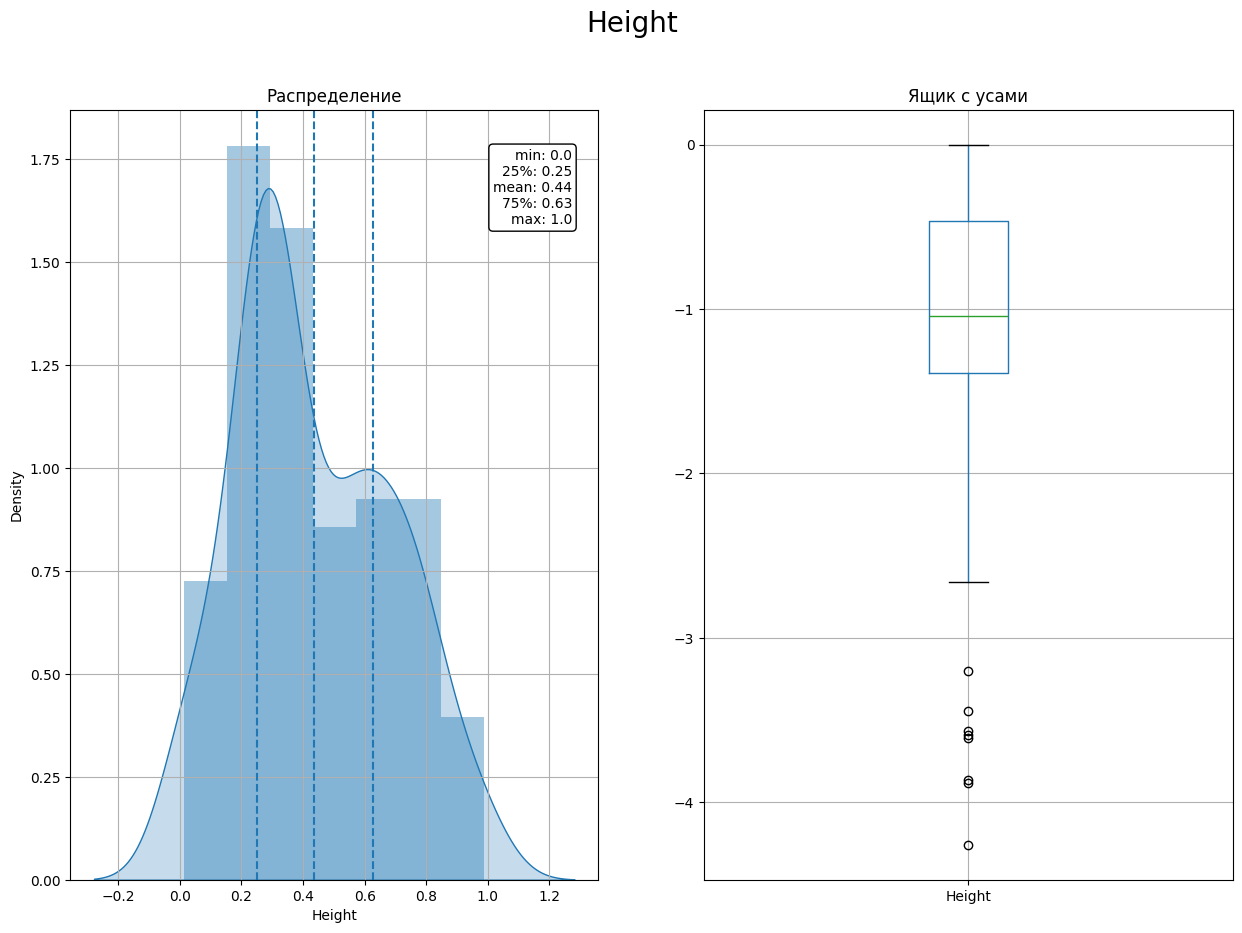

In [ ]:
# Нарисуем графики для переменной "высота" по обучающему датасету,
# поскольку данные в нём уже подготовлены
show_dist('Height', train_x_scaled)

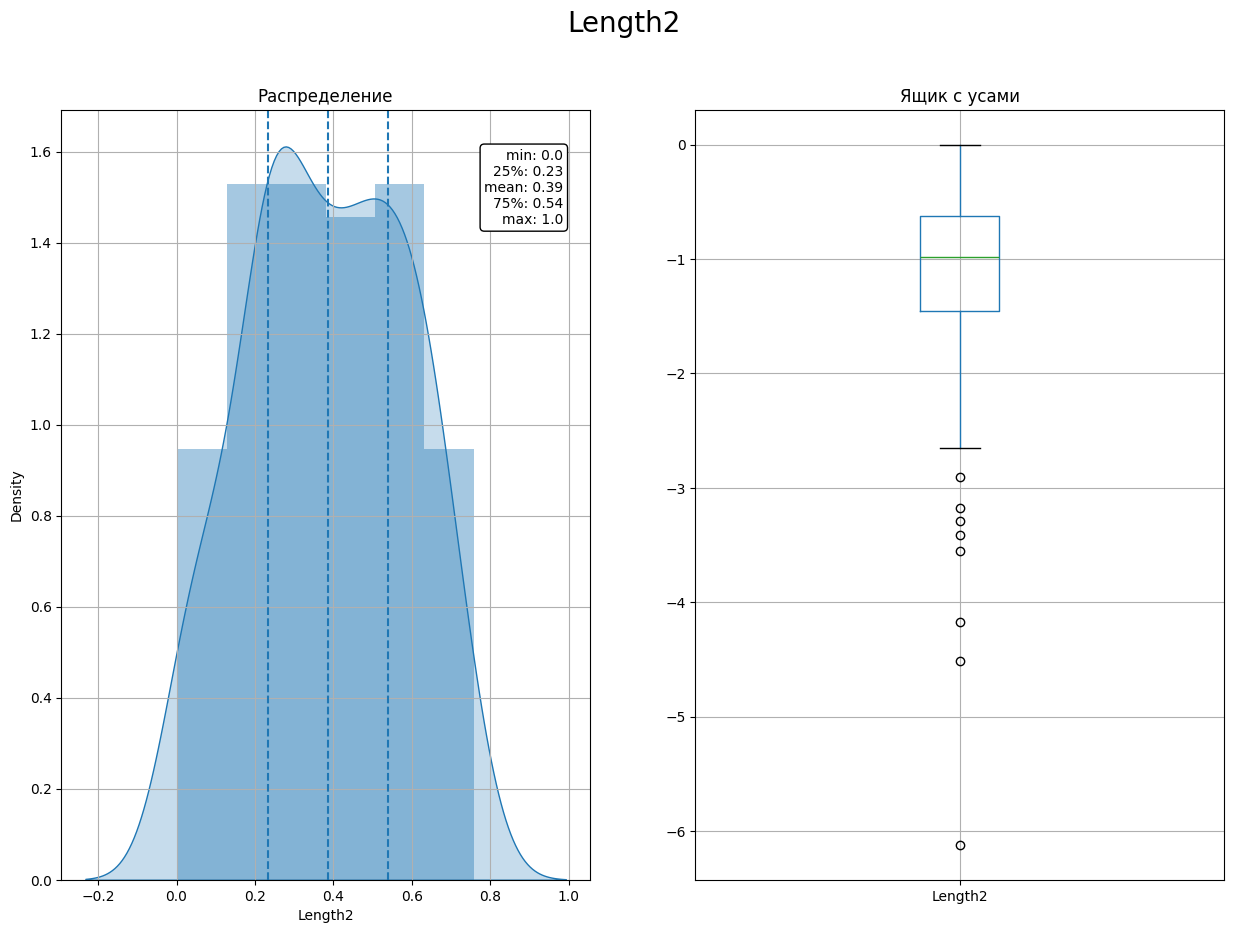

In [ ]:
show_dist('Length2', train_x_scaled) # Нарисуем график "длины2"

In [ ]:
# Выведем результат нормализации
X

array([[0.096     , 0.23809524, 0.25274725, 0.24740125, 0.2543213 ,
        0.32302391],
       [0.548     , 0.57142857, 0.57142857, 0.56964657, 0.53124456,
        0.8172615 ],
       [0.18      , 0.28571429, 0.2967033 , 0.28898129, 0.3229862 ,
        0.36813658],
       [0.74      , 0.62380952, 0.63736264, 0.7006237 , 0.98822888,
        0.80091798],
       [0.1       , 0.21428571, 0.23076923, 0.22661123, 0.23008834,
        0.36020075],
       [0.8       , 0.70952381, 0.71428571, 0.6985447 , 0.59229421,
        0.87634409],
       [0.24      , 0.59047619, 0.58901099, 0.58627859, 0.26467618,
        0.41057538],
       [0.096     , 0.17857143, 0.18681319, 0.2016632 , 0.38678709,
        0.25304564],
       [0.672     , 0.53571429, 0.53846154, 0.53430353, 0.56649989,
        0.9504833 ],
       [0.8       , 0.55952381, 0.58241758, 0.64449064, 1.        ,
        0.77994166],
       [0.00784   , 0.03333333, 0.03296703, 0.03326403, 0.02762848,
        0.        ],
       [0.256     , 0

In [ ]:
# Выведем индексы обучающей выборки
train_x.index

Index([ 86, 112,  96,  32,  84, 124, 131,  64, 111,  29,
       ...
       122, 106,  37,  36, 148,  28,  74,  88, 117,   7],
      dtype='int64', length=111)

In [ ]:
# Нормализуем тестовую выборку
X = scaler.fit_transform(test_x)

test_x_scaled = pd.DataFrame(X, columns=test_x.columns,index=test_x.index )
test_y_scaled = test_y

Text(0.5, 1.0, 'Корреляция Пирсона')

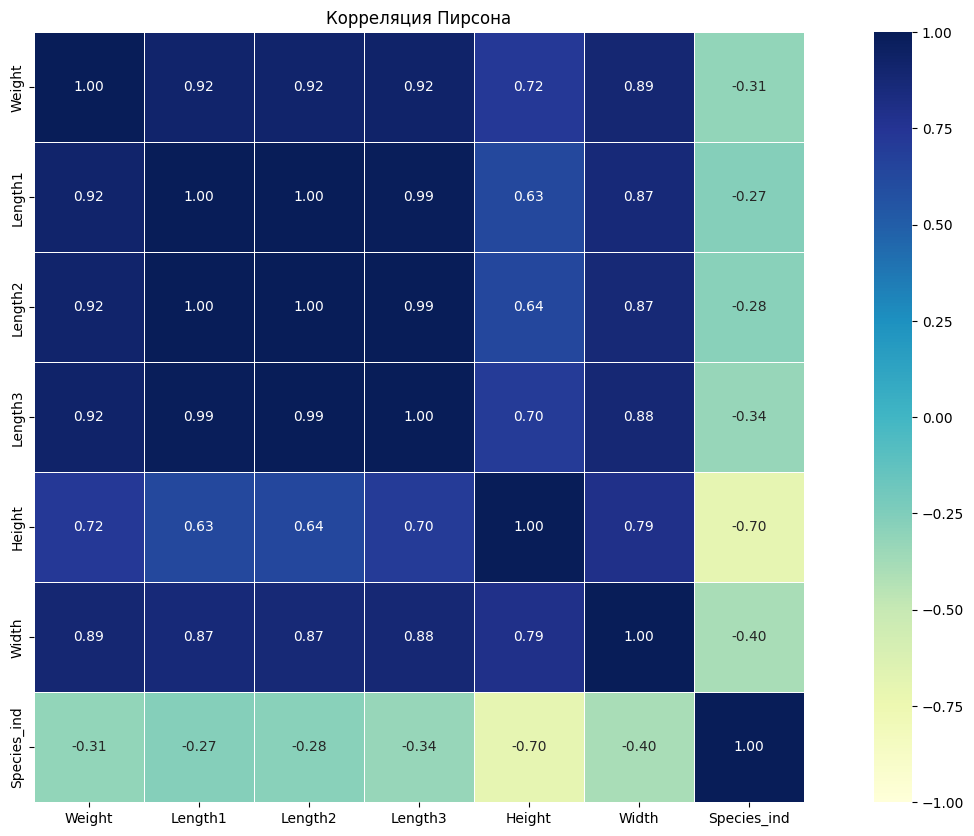

In [ ]:
# Вычисляем матрицу корреляций
corr_matrix = dataset.copy()
plt.figure(figsize=(18,10),dpi=100)

for col in corr_matrix.columns: # Зададим условия для столбцов object
  if corr_matrix[col].dtype == "O":
      corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson",numeric_only = True)
# Визуализируем матрицу корреляции
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True)
plt.title("Корреляция Пирсона")

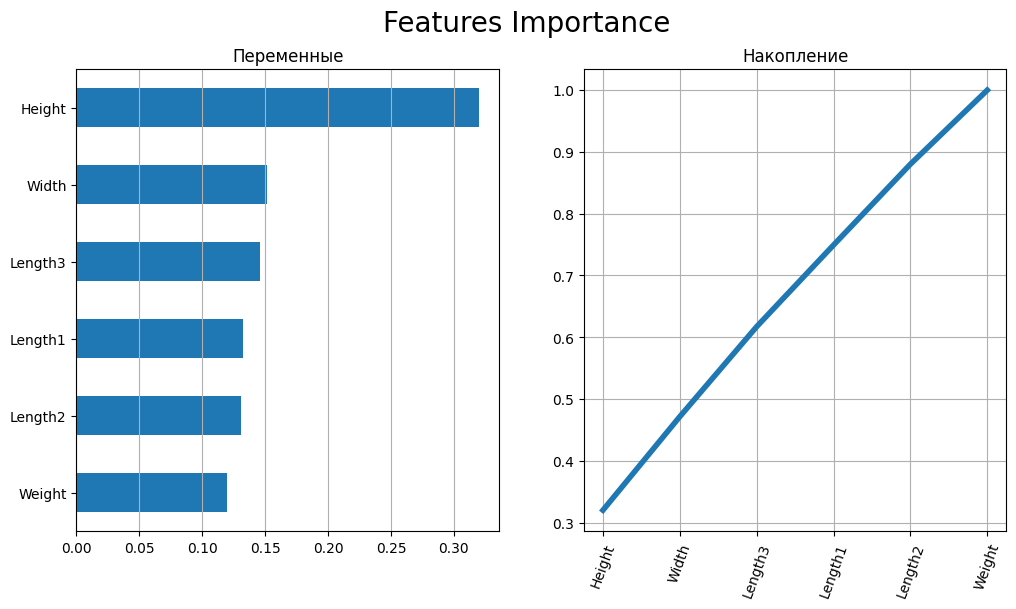

In [ ]:
# Оценим важность каждого столбца
X = train_x_scaled.values
y = train_y_scaled.values
feature_names = train_x_scaled.columns.tolist() # Имена столбцов в датасете.
# Важность параметров
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ # Это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
# Создаём датафрейм
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")


# Графики
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(12,6),dpi=100) # Распаковываем  кортеж в переменные fig и ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('Переменные') # Подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('Накопление') # Подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both') # Настроим сетку.

plt.show()

In [ ]:
# Выбираем для модели наиболее значимые признаки
X_train = train_x_scaled[['Weight', 'Length1',	'Length2',	'Length3',	'Height',	'Width']]
y_train = train_y_scaled

X_test = test_x_scaled[['Weight', 'Length1',	'Length2',	'Length3',	'Height',	'Width']]
y_test = test_y_scaled

In [ ]:
# Строим модель - градиентный бустинг
model = ensemble.GradientBoostingClassifier()
# Выбираем гиперпараметры
param_dic = {'learning_rate':[0.15,0.1,0.05], # Весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500], # Количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5], # Максимальная глубина дерева
             'min_samples_split':[2,4,6], # Задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5], # Минимальное количество выборок для формирования листа
             'max_features':[2,3,4], # Квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]}  # Образцы, которые будут использоваться для подгонки индивидуального базового файла
# Рандомизированный поиск по гиперпараметрам
random_search = model_selection.RandomizedSearchCV(model,
                                                   param_distributions=param_dic, n_iter=10,
                                                   scoring="accuracy").fit(X_train, y_train)
# Выведем параметры
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_   # Здесь теперь хранятся параметры, при которых были получены наилучшие метрики на обучающей выборке

Best Model parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.05}
Best Model mean accuracy: 0.8292490118577076


In [ ]:
# Обучаем модель
model.fit(X_train, y_train)
# Выполняем прогнозирование на тестовой выборке
predicted_prob = model.predict_proba(X_test)
predicted = model.predict(X_test).astype('int32')

In [ ]:
# Вероятность отнесения значения к каждому из классов
predicted_prob

array([[1.06900348e-02, 1.85091519e-02, 4.81217136e-01, 4.16985517e-03,
        4.59975796e-02, 4.38101728e-01, 1.31451420e-03],
       [6.19865614e-04, 1.51445140e-04, 2.57903455e-02, 9.72207899e-01,
        3.84310327e-04, 1.86141530e-04, 6.59992918e-04],
       [3.60079156e-04, 4.39711441e-04, 8.06667086e-03, 1.36905700e-04,
        2.12185043e-02, 9.69734920e-01, 4.32084457e-05],
       [3.57474965e-03, 1.12591778e-03, 4.40371251e-01, 1.22956524e-03,
        5.50276878e-01, 1.39298149e-03, 2.02865659e-03],
       [1.17211417e-02, 1.96739684e-03, 4.03235947e-01, 5.71415916e-01,
        4.97792890e-03, 2.41520538e-03, 4.26646466e-03],
       [9.95820907e-01, 3.18953171e-05, 3.97946934e-03, 3.50753469e-05,
        8.05670761e-05, 3.92773485e-05, 1.28088957e-05],
       [6.77025350e-03, 5.40565880e-03, 4.59575027e-01, 2.67554744e-03,
        5.22083181e-01, 2.64571844e-03, 8.44614423e-04],
       [1.91854984e-03, 2.96583674e-03, 1.48677552e-01, 6.59562812e-04,
        8.44241763e-01, 7

In [ ]:
# Реальные значения классов
y_test.astype('int32')

,Species_ind
157,5
142,3
151,5
51,4
139,3
27,0
38,4
50,4
78,2
143,3


In [ ]:
# Оценим точность классификации и производительность модели
accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted,  multi_class='ovo',average= "weighted")

print("Accuracy (overall correct predictions):",  round(accuracy,2))
# print("Auc:", round(auc,2))

# Выведем характеристики модели
recall = metrics.recall_score(y_test, predicted, average="weighted")
precision = metrics.precision_score(y_test, predicted, average="weighted")
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.56
Recall (all 1s predicted right): 0.56
Precision (confidence when predicting a 1): 0.58
Detail:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.00      0.00      0.00         3
           2       0.29      0.60      0.39        10
           3       1.00      0.67      0.80         9
           4       0.62      0.42      0.50        12
           5       0.75      0.75      0.75         4
           6       0.00      0.00      0.00         3

    accuracy                           0.56        48
   macro avg       0.49      0.49      0.47        48
weighted avg       0.58      0.56      0.55        48



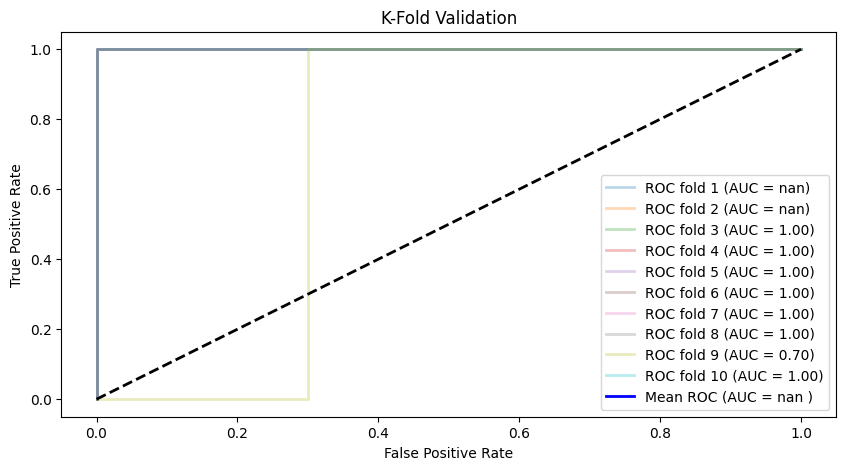

In [ ]:
# Строим семейство ROC  кривых
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure(figsize=(10,5),dpi=100)
i = 1
for train, test in cv.split(X_train, y_train):
    X_train_selected = X_train.iloc[train]

    y_train_selected = y_train.iloc[train]
    X_train_selected_test = X_train.iloc[test]
    y_train_selected_test = y_train.iloc[test]

    prediction = model.fit(X_train_selected, y_train_selected).predict_proba(X_train_selected_test)
    fpr, tpr, t = metrics.roc_curve(y_train_selected_test, prediction[:, 1], pos_label=1)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
# Результат
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
# Выведем ROC кривые
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")

plt.show()

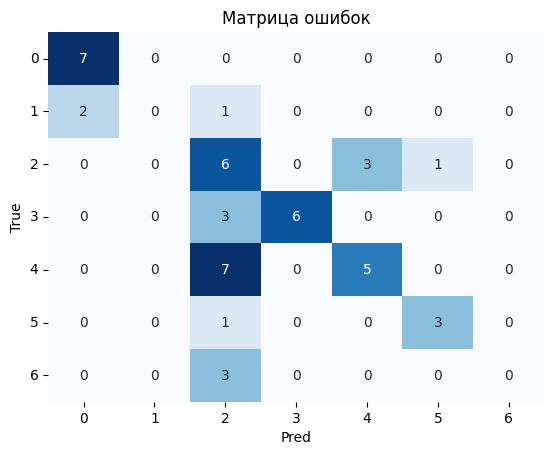

In [ ]:
# Строим матрицу ошибок
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Матрица ошибок")
ax.set_yticklabels(labels=classes, rotation=0)

plt.show()

In [ ]:
# Функция для построения матрицы для каждого класса
def compute_class(ls_res, class_value):
    y_t_class = ls_res.copy().astype(int)
    y_t_class = y_t_class.apply(lambda c: 1 if c  == class_value  else 0)
    return  y_t_class

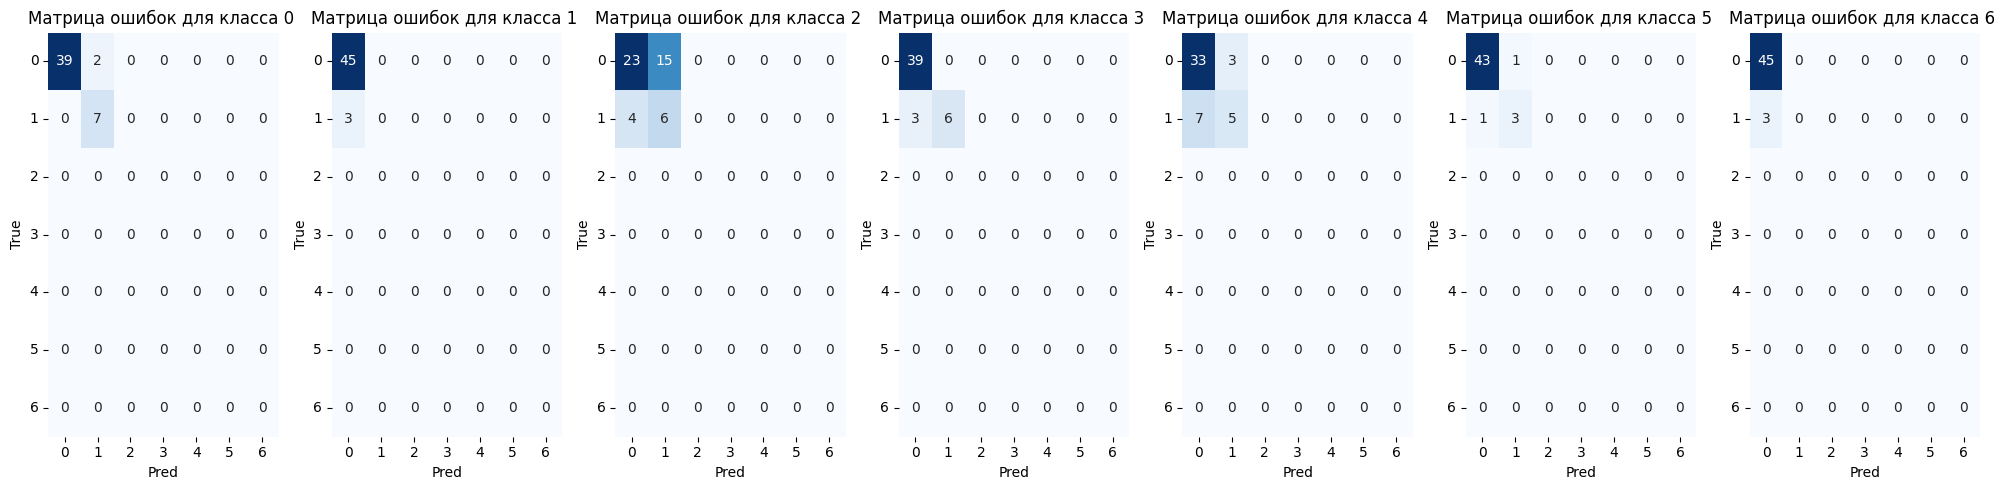

In [ ]:
# Построим матрицы ошибок для каждого класса
classes = np.unique(y_test).astype(int)  # Массив классов
lbs = np.arange(7)  # Обновляем, чтобы учитывать 7 классов
fig, ax = plt.subplots(nrows=1, ncols=len(lbs), figsize=(20, 5), dpi=100)

for class_i in classes:
    y_one_class = compute_class(y_test, class_i)
    predicted_one_class = compute_class(pd.Series(predicted.tolist()), class_i)  # возвращает строку имен классов
    cm = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, ax=ax[class_i])
    ax[class_i].set(xlabel="Pred", ylabel="True", title=f"Матрица ошибок для класса {class_i} ")
    ax[class_i].set_xticklabels(labels=lbs, rotation=0)
    ax[class_i].set_yticklabels(labels=lbs, rotation=0)

# Выводим
plt.tight_layout()  # Чтобы избежать наложения графиков
plt.show()

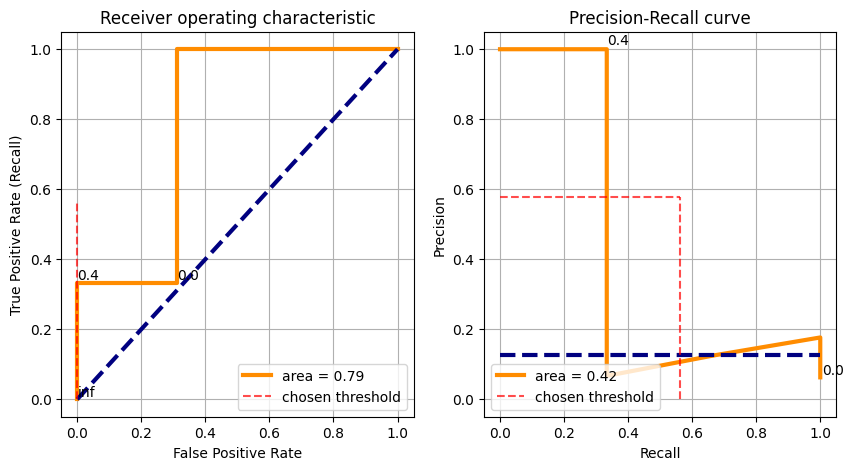

In [ ]:
# Построим ещё ROC кривые
classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5),dpi=100)

fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# Найдем пороговые значения
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next

# Построим график
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob[:,1], pos_label=1)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

# Пороговые значения P-R
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
        ax[1].annotate(np.round(t,1), xy=(recalls[i],precisions[i]),
                    xytext=(recalls[i],precisions[i]),
                    textcoords='offset points', ha='left', va='bottom')
        thres_in_plot.append(t)
    else:
        next
plt.show()

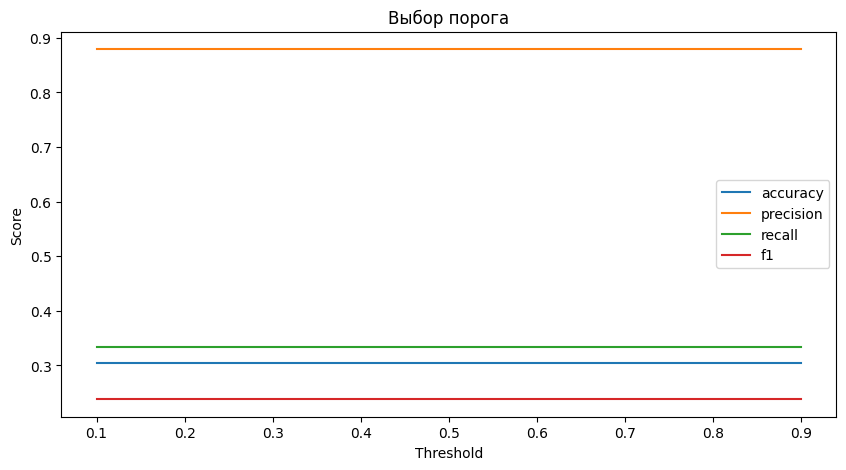

In [ ]:
# Построим графики значений отсечки для каждой метрики
# Значения метрик для различных пороговых значений вхождения в класс
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted, average='macro'))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted, average='macro'))

# Строим графики
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Выбор порога")
dtf_scores.plot(ax=ax)

plt.show()